## Problem 1 平行板电容器等势线

松弛迭代法求解。直接假定边界条件是Neumann条件，板子有限大，但在代码中体现的性质接近无限大

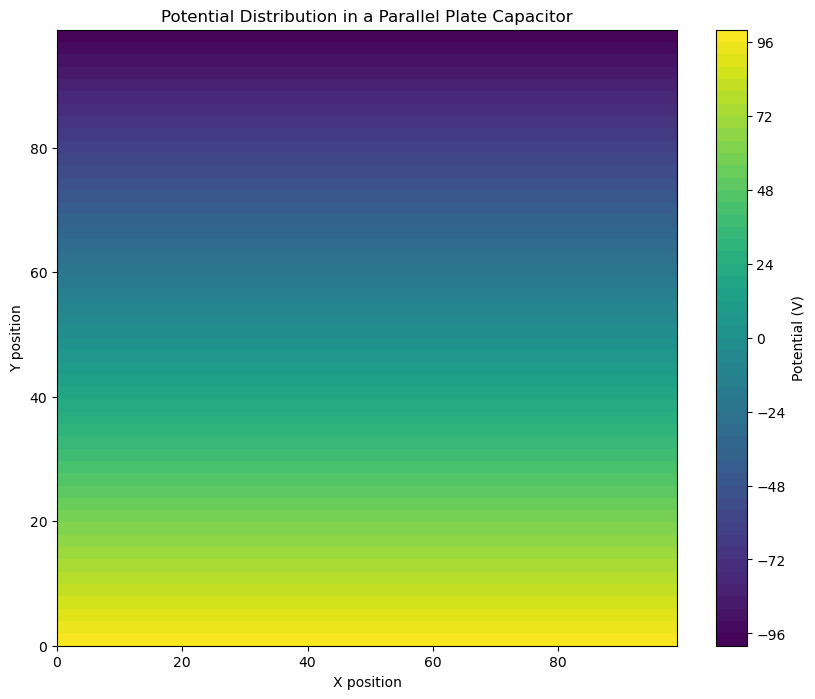

Number of iterations for convergence: 8715


In [6]:
import numpy as np
import matplotlib.pyplot as plt

def laplace_solve(relaxation_factor=1.0, max_iterations=10000, tolerance=1e-5):
    # 设置网格大小和电势边界条件
    n = 100  # 网格点数
    V = np.zeros((n, n))
    V[0, :] = 100  # 上边界电势
    V[-1, :] = -100  # 下边界电势
    
    # 迭代求解Laplace方程
    for iteration in range(max_iterations):
        V_old = V.copy()
        
        # 使用松弛迭代法更新网格点电势
        for i in range(1, n-1):
            for j in range(1, n-1):
                V[i, j] = ((V[i+1, j] + V[i-1, j] + V[i, j+1] + V[i, j-1]) / 4.0) * relaxation_factor \
                          + V[i, j] * (1 - relaxation_factor)
        
        # 边界处理：Neumann条件，假设边界外的电势与边界相同
        V[:, 0] = V[:, 1]
        V[:, -1] = V[:, -2]
        
        # 检查收敛性
        if np.max(np.abs(V - V_old)) < tolerance:
            break
    
    return V, iteration

# 解Laplace方程
V, iterations = laplace_solve()

# 绘制电势分布和等势线
plt.figure(figsize=(10, 8))
plt.contourf(V, levels=50, cmap='viridis')
plt.colorbar(label='Potential (V)')
plt.title('Potential Distribution in a Parallel Plate Capacitor')
plt.xlabel('X position')
plt.ylabel('Y position')
plt.show()

print(f"Number of iterations for convergence: {iterations}")


这张图用时1min8s 

上面是热力图，下面是三维坐标图

In [21]:
def laplace_solve_realistic(n=100, aspect_ratio=5, relaxation_factor=1.0, max_iterations=10000, tolerance=1e-4):
    # 生成更窄长的网格模型，模拟电容器的形状
    m = n * aspect_ratio  # y方向长度是x方向的五倍
    V = np.zeros((n, m))
    V[0, :] = 100  # 上边界电势
    V[-1, :] = -100  # 下边界电势
    
    # 高斯-塞德尔迭代法
    for iteration in range(max_iterations):
        V_old = V.copy()
        
        for i in range(1, n-1):
            for j in range(1, m-1):
                V[i, j] = (V[i+1, j] + V[i-1, j] + V[i, j+1] + V[i, j-1]) / 4.0
        
        # 边界处理：Neumann条件，假设边界外的电势与边界相同
        V[:, 0] = V[:, 1]
        V[:, -1] = V[:, -2]
        
        # 检查收敛性
        if np.max(np.abs(V - V_old)) < tolerance:
            break
    
    return V, iteration

# 解Laplace方程
V_realistic, iterations_realistic = laplace_solve_realistic()

# 创建网格坐标
x = np.linspace(0, 1, V_realistic.shape[1])
y = np.linspace(0, 1, V_realistic.shape[0])
X, Y = np.meshgrid(x, y)

# 绘制3D图
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, V_realistic, cmap='viridis')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
ax.set_xlabel('X position')
ax.set_ylabel('Y position')
ax.set_zlabel('Potential (V)')
ax.set_title('3D Visualization of Realistic Potential Distribution in a Parallel Plate Capacitor')
plt.show()

print(f"Number of iterations for convergence: {iterations_realistic}")


KeyboardInterrupt: 

这段代码被我强行终止了，因为他运行了5min以上，速度实在是太慢了。下面我将引入深度学习的pytorch，开CUDA调用GPU进行加速。使用Pytorch代替Numpy库，使用张量运算来代替原有的双层循环。

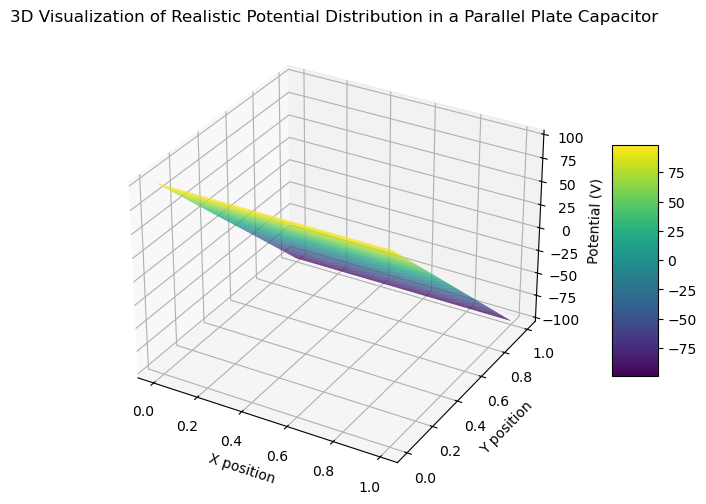

收敛所需迭代次数: 6413


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def laplace_solve_realistic_torch(n=100, aspect_ratio=5, max_iterations=10000, tolerance=1e-4, device='cuda'):
    m = n * aspect_ratio  # y方向长度是x方向的五倍
    V = torch.zeros((n, m), device=device)  # 在指定设备上初始化电势数组
    
    # 设定边界条件
    V[0, :] = 100  # 上边界电势
    V[-1, :] = -100  # 下边界电势
    
    # 使用PyTorch进行迭代求解
    for iteration in range(max_iterations):
        V_old = V.clone()  # 拷贝原始数据用于后续比较
        
        # 更新内部点的电势值
        V[1:-1, 1:-1] = (V[2:, 1:-1] + V[:-2, 1:-1] + V[1:-1, 2:] + V[1:-1, :-2]) * 0.25
        
        # Neumann边界条件，假设边界外电势与边界相同
        V[:, 0] = V[:, 1]
        V[:, -1] = V[:, -2]
        
        # 检查收敛性
        if torch.max(torch.abs(V - V_old)) < tolerance:
            break

    return V, iteration

# 设定运行设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 在GPU上求解Laplace方程
V_realistic_torch, iterations_torch = laplace_solve_realistic_torch(device=device)

# 将数据从GPU转移到CPU，用于绘图
V_realistic_torch = V_realistic_torch.cpu().numpy()


# 创建网格坐标
x = np.linspace(0, 1, V_realistic_torch.shape[1])
y = np.linspace(0, 1, V_realistic_torch.shape[0])
X, Y = np.meshgrid(x, y)

# 绘制3D图形
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, V_realistic_torch, cmap='viridis')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
ax.set_xlabel('X position')
ax.set_ylabel('Y position')
ax.set_zlabel('Potential (V)')
ax.set_title('3D Visualization of Realistic Potential Distribution in a Parallel Plate Capacitor')
plt.show()

print(f"收敛所需迭代次数: {iterations_torch}")



我最初用numpy求这个图，只有5000次迭代，跑了很久，现在改成10000次迭代，只需要2.1秒。pytorch效率远远高于numpy，深度学习赢！

## Problem 2 有厚度平行板电容器等势线

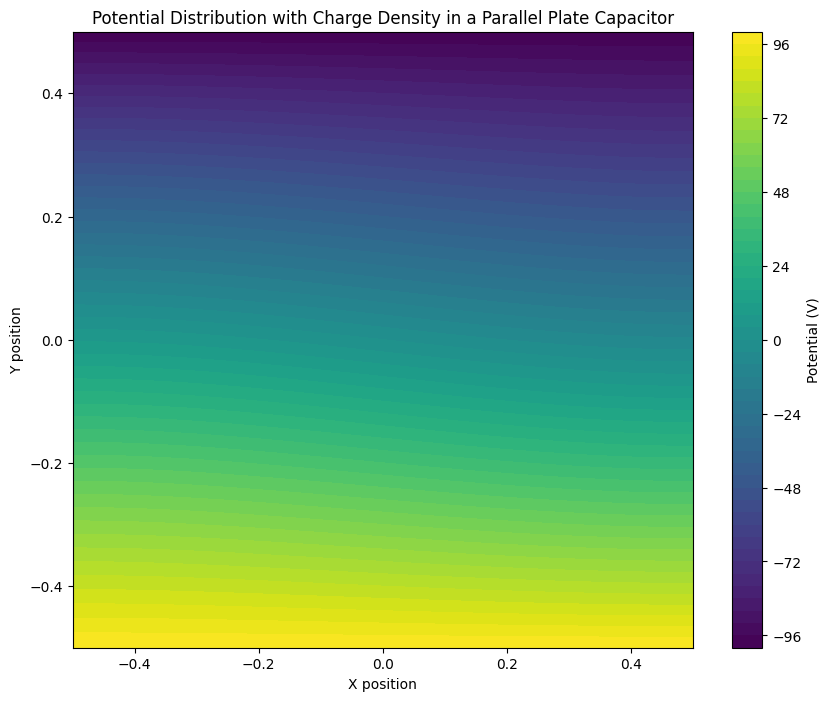

Number of iterations for convergence: 2075


In [5]:
def poisson_solve(n=50, max_iterations=10000, tolerance=1e-4, delta=0.1):
    # 创建网格点坐标
    x = np.linspace(-0.5, 0.5, n)
    y = np.linspace(-0.5, 0.5, n)
    X, Y = np.meshgrid(x, y)
    
    # 计算电荷密度ρ(x) = -4πx
    rho = -4 * np.pi * X
    
    # 设置电势的初始值和边界条件
    V = np.zeros((n, n))
    V[0, :] = 100
    V[-1, :] = -100
    
    # 迭代求解泊松方程
    for iteration in range(max_iterations):
        V_old = V.copy()
        
        for i in range(1, n-1):
            for j in range(1, n-1):
                V[i, j] = 0.25 * (V[i+1, j] + V[i-1, j] + V[i, j+1] + V[i, j-1] + delta**2 * rho[i, j])
        
        # 边界处理：Neumann条件，假设边界外的电势与边界相同
        V[:, 0] = V[:, 1]
        V[:, -1] = V[:, -2]
        
        # 检查收敛性
        if np.max(np.abs(V - V_old)) < tolerance:
            break
    
    return V, iteration, X, Y

# 解泊松方程
V_poisson, iterations_poisson, X, Y = poisson_solve()

# 绘制电势分布和等势线
plt.figure(figsize=(10, 8))
plt.contourf(X, Y, V_poisson, levels=50, cmap='viridis')
plt.colorbar(label='Potential (V)')
plt.title('Potential Distribution with Charge Density in a Parallel Plate Capacitor')
plt.xlabel('X position')
plt.ylabel('Y position')
plt.show()

print(f"Number of iterations for convergence: {iterations_poisson}")


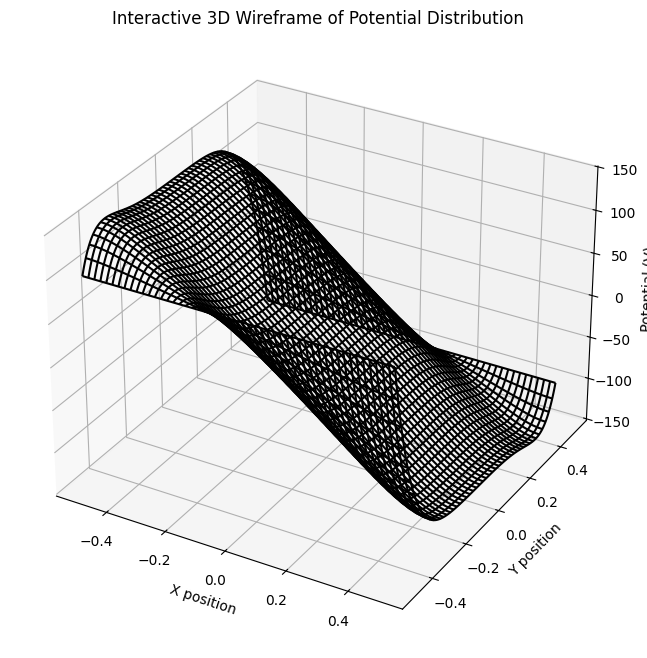

In [18]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def poisson_solve_interactive(n=500, max_iterations=5000, tolerance=1e-4, delta=0.1):
    # 创建网格点坐标
    x = np.linspace(-0.5,0.5, n)
    y = np.linspace(-0.5,0.5, n)
    X, Y = np.meshgrid(x, y)
    
    # 计算电荷密度ρ(x) = -4πx
    rho = -4 * np.pi * X
    
    # 设置电势的初始值和边界条件
    V = np.zeros((n, n))
    V[0, :] = 100
    V[-1, :] = -100
    
    # 迭代求解泊松方程
    for iteration in range(max_iterations):
        V_old = V.copy()
        
        for i in range(1, n-1):
            for j in range(1, n-1):
                V[i, j] = 0.25 * (V[i+1, j] + V[i-1, j] + V[i, j+1] + V[i, j-1] + delta**2 * rho[i, j])
        
        # 边界处理：Neumann条件，假设边界外的电势与边界相同
        V[:, 0] = V[:, 1]
        V[:, -1] = V[:, -2]
        
        # 检查收敛性
        if np.max(np.abs(V - V_old)) < tolerance:
            break
    
    return V, X, Y

# 解泊松方程并绘制交互式3D图
V_interactive, X_interactive, Y_interactive = poisson_solve_interactive()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
wire = ax.plot_wireframe(X_interactive, Y_interactive, V_interactive, color='black')
ax.set_xlabel('X position')
ax.set_ylabel('Y position')
ax.set_zlabel('Potential (V)')
ax.set_title('Interactive 3D Wireframe of Potential Distribution')

plt.show()


这是1m尺度下的板子，然后我网格选了500个，迭代次数越多其实会有一个大的偏差，因为边界条件的近似会出现问题，我现在让这个板子再大一点，网格选100次，再试一下（上面这个图跑了15min23s）

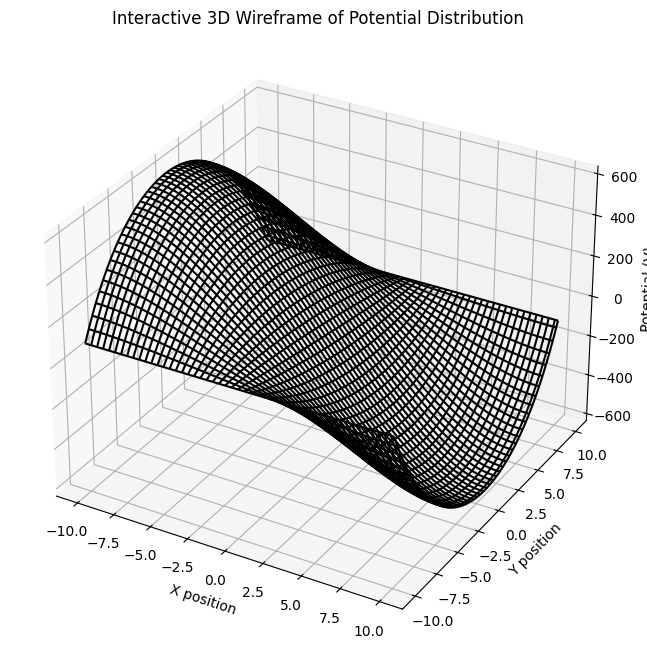

In [19]:
def poisson_solve_interactive(n=100, max_iterations=5000, tolerance=1e-4, delta=0.1):
    # 创建网格点坐标
    x = np.linspace(-10,10, n)
    y = np.linspace(-10,10, n)
    X, Y = np.meshgrid(x, y)
    
    # 计算电荷密度ρ(x) = -4πx
    rho = -4 * np.pi * X
    
    # 设置电势的初始值和边界条件
    V = np.zeros((n, n))
    V[0, :] = 100
    V[-1, :] = -100
    
    # 迭代求解泊松方程
    for iteration in range(max_iterations):
        V_old = V.copy()
        
        for i in range(1, n-1):
            for j in range(1, n-1):
                V[i, j] = 0.25 * (V[i+1, j] + V[i-1, j] + V[i, j+1] + V[i, j-1] + delta**2 * rho[i, j])
        
        # 边界处理：Neumann条件，假设边界外的电势与边界相同
        V[:, 0] = V[:, 1]
        V[:, -1] = V[:, -2]
        
        # 检查收敛性
        if np.max(np.abs(V - V_old)) < tolerance:
            break
    
    return V, X, Y

# 解泊松方程并绘制交互式3D图
V_interactive, X_interactive, Y_interactive = poisson_solve_interactive()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
wire = ax.plot_wireframe(X_interactive, Y_interactive, V_interactive, color='black')
ax.set_xlabel('X position')
ax.set_ylabel('Y position')
ax.set_zlabel('Potential (V)')
ax.set_title('Interactive 3D Wireframe of Potential Distribution')

plt.show()

注意！这个东西的试图和我们题目给的哪个视图的观察视角是不一样的，但实际上是一样的，都是一个类马鞍面，前后看上去是卷曲的是因为视觉差别带来的，仔细观察，就是一个上凸的山丘和下凹的山丘，注意视角是不同的！
第二点，我们上面那个图，和这个图的弯曲是有区别的，最初小尺度1m的板子他那个鞍面和这个大尺度的20m板子的鞍面有区别，这说明这个板子的边界条件带来的pde方程的求解的影响是非常大的。（这玩意确实耗时，改日看看流体力学他们是如何加速pde的算法，嫁接以下，嘻嘻）

要不再放大一下？和图示差不多的尺寸。

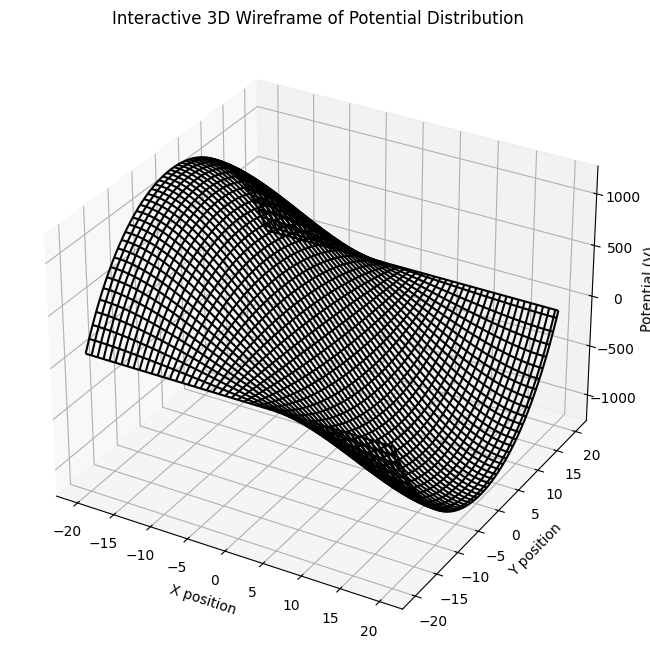

In [22]:
def poisson_solve_interactive(n=100, max_iterations=5000, tolerance=1e-4, delta=0.1):
    # 创建网格点坐标
    x = np.linspace(-20,20, n)
    y = np.linspace(-20,20, n)
    X, Y = np.meshgrid(x, y)
    
    # 计算电荷密度ρ(x) = -4πx
    rho = -4 * np.pi * X
    
    # 设置电势的初始值和边界条件
    V = np.zeros((n, n))
    V[0, :] = 100
    V[-1, :] = -100
    
    # 迭代求解泊松方程
    for iteration in range(max_iterations):
        V_old = V.copy()
        
        for i in range(1, n-1):
            for j in range(1, n-1):
                V[i, j] = 0.25 * (V[i+1, j] + V[i-1, j] + V[i, j+1] + V[i, j-1] + delta**2 * rho[i, j])
        
        # 边界处理：Neumann条件，假设边界外的电势与边界相同
        V[:, 0] = V[:, 1]
        V[:, -1] = V[:, -2]
        
        # 检查收敛性
        if np.max(np.abs(V - V_old)) < tolerance:
            break
    
    return V, X, Y

# 解泊松方程并绘制交互式3D图
V_interactive, X_interactive, Y_interactive = poisson_solve_interactive()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
wire = ax.plot_wireframe(X_interactive, Y_interactive, V_interactive, color='black')
ax.set_xlabel('X position')
ax.set_ylabel('Y position')
ax.set_zlabel('Potential (V)')
ax.set_title('Interactive 3D Wireframe of Potential Distribution')

plt.show()

效果差不多，看来20m尺寸够大了

但是实际上我们发现求解上面这三张图，耗时还是太长了，而且实际上这个图和严格解的图总是有区别的，马鞍的“褶皱”的折叠是有问题的，这说明在收敛的时候，他对于边界条件的处理是由问题的。和第一题的思路一样，还是用深度学习来干这个题目。用Pytorch代替numpy，用张量运算代替原有的循环，用GPU（我的设备是NVIDIA RTX 3060）进行加速，上面的迭代次数都是5000，这里我们提高一下数量级，让他更精确。

设置iterations为100000！加速！

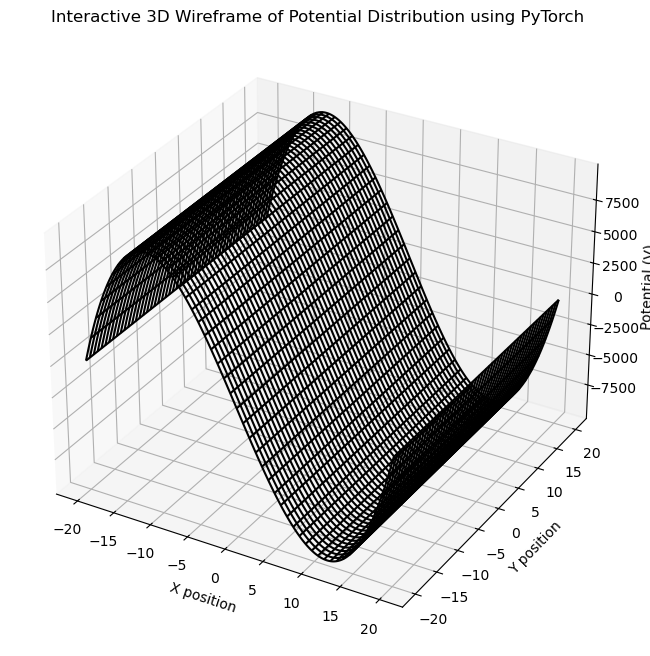

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def poisson_solve_interactive_torch(n=500, max_iterations=100000, tolerance=1e-4, delta=0.1, device='cuda'):
    # 创建网格点坐标
    x = torch.linspace(-20, 20, n, device=device)
    y = torch.linspace(-20, 20, n, device=device)
    X, Y = torch.meshgrid(x, y, indexing='ij')
    
    # 计算电荷密度ρ(x) = -4πx
    rho = -4 * np.pi * X
    
    # 设置电势的初始值和边界条件
    V = torch.zeros((n, n), device=device)
    V[0, :] = 100
    V[-1, :] = -100
    
    # 迭代求解泊松方程
    for iteration in range(max_iterations):
        V_old = V.clone()
        
        # 使用张量操作更新电势值
        V[1:-1, 1:-1] = 0.25 * (V[2:, 1:-1] + V[:-2, 1:-1] + V[1:-1, 2:] + V[1:-1, :-2] + delta**2 * rho[1:-1, 1:-1])
        
        # 边界处理：Neumann条件
        V[:, 0] = V[:, 1]
        V[:, -1] = V[:, -2]
        
        # 检查收敛性
        if torch.max(torch.abs(V - V_old)) < tolerance:
            break
    
    return V.cpu(), X.cpu(), Y.cpu()

# 设定运行设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 在GPU上求解泊松方程
V_interactive_torch, X_interactive_torch, Y_interactive_torch = poisson_solve_interactive_torch(device=device)

# 绘制交互式3D图
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
wire = ax.plot_wireframe(X_interactive_torch.numpy(), Y_interactive_torch.numpy(), V_interactive_torch.numpy(), color='black')
ax.set_xlabel('X position')
ax.set_ylabel('Y position')
ax.set_zlabel('Potential (V)')
ax.set_title('Interactive 3D Wireframe of Potential Distribution using PyTorch')

plt.show()

用时28.5秒就完成了，我们发现，这个和雨课堂的标准答案是一样的（观察视角不同可能会有视觉影响），这个的边界条件更好

## Problem 3 求解Possion方程

注：我下面的代码中把正电荷放在了左上角，负电荷放在了右下角。原题目中式正电荷在右上角，负电荷在左下角。这并不影响，因为这是对称的。

下面的第一段是传统PDE解法，因为太耗时，我终止了它的运行，然后再第二段代码中直接用的深度学习pytorch代替numpy，用GPU加速。



In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
size = 100  # size of the box in cm
charge_size = 20  # size of the charge squares
epsilon_0 = 1  # permittivity in vacuum
rho_pos = 1  # positive charge density in C/m^2
rho_neg = -1  # negative charge density in C/m^2
tolerance = 1e-6  # tolerance for potential change

# Create arrays for potential and charge density
phi = np.zeros((size, size))
rho = np.zeros((size, size))

# Set up the charge distribution
x0_pos = 60  # x position of the bottom left corner of the positive charge
y0_pos = 60  # y position of the bottom left corner of the positive charge
x0_neg = 20  # x position of the bottom left corner of the negative charge
y0_neg = 20  # y position of the bottom left corner of the negative charge

rho[y0_pos:y0_pos+charge_size, x0_pos:x0_pos+charge_size] = rho_pos
rho[y0_neg:y0_neg+charge_size, x0_neg:x0_neg+charge_size] = rho_neg

# Function to perform the Jacobi iteration
def jacobi(phi, rho):
    phi_new = phi.copy()
    for i in range(1, size-1):
        for j in range(1, size-1):
            phi_new[i, j] = 0.25 * (phi[i+1, j] + phi[i-1, j] + phi[i, j+1] + phi[i, j-1] - rho[i, j])
    return phi_new

# Iterative solver
delta = np.inf
while delta > tolerance:
    phi_new = jacobi(phi, rho)
    delta = np.max(np.abs(phi_new - phi))
    phi = phi    .copy()

# Plotting
plt.imshow(phi, extent=(0, size, 0, size), origin='lower', cmap='viridis')
plt.colorbar(label='Potential (V)')
plt.title('Electric Potential Distribution')
plt.xlabel('x (cm)')
plt.ylabel('y (cm)')
plt.show()


KeyboardInterrupt: 

耗时，受不了了，GPU启动！CUDA加速启动！（当然我也同时优化了一下算法，为了更清晰，提高了dpi）

In [6]:
# 设置参数
L = 100  # 箱子边长(cm)
d = 20  # 电荷边长(cm)

# 使用PyTorch tensors初始化电势和电荷密度
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 选择设备

V = torch.zeros((L, L), device=device, dtype=torch.float32)  # 电势
rho = torch.zeros((L, L), device=device, dtype=torch.float32)  # 电荷密度

# 设置电荷位置
offset = (L - d) // 2 - d
rho[offset:offset + d, offset:offset + d] = 1  # 正电荷
rho[L-offset-d:L-offset, L-offset-d:L-offset] = -1  # 负电荷

In [7]:
def poisson_solver(V, rho, iterations=100000, tol=1e-6):
    V = V.clone()
    for _ in range(iterations):
        V_old = V.clone()
        # 通过平均相邻值来更新电势
        V[1:-1, 1:-1] = 0.25 * (V[:-2, 1:-1] + V[2:, 1:-1] + V[1:-1, :-2] + V[1:-1, 2:] + rho[1:-1, 1:-1])
        # 边界条件: V=0
        V[0, :], V[-1, :], V[:, 0], V[:, -1] = 0, 0, 0, 0
        # 检查收敛性
        if torch.max(torch.abs(V - V_old)) < tol:
            break
    return V

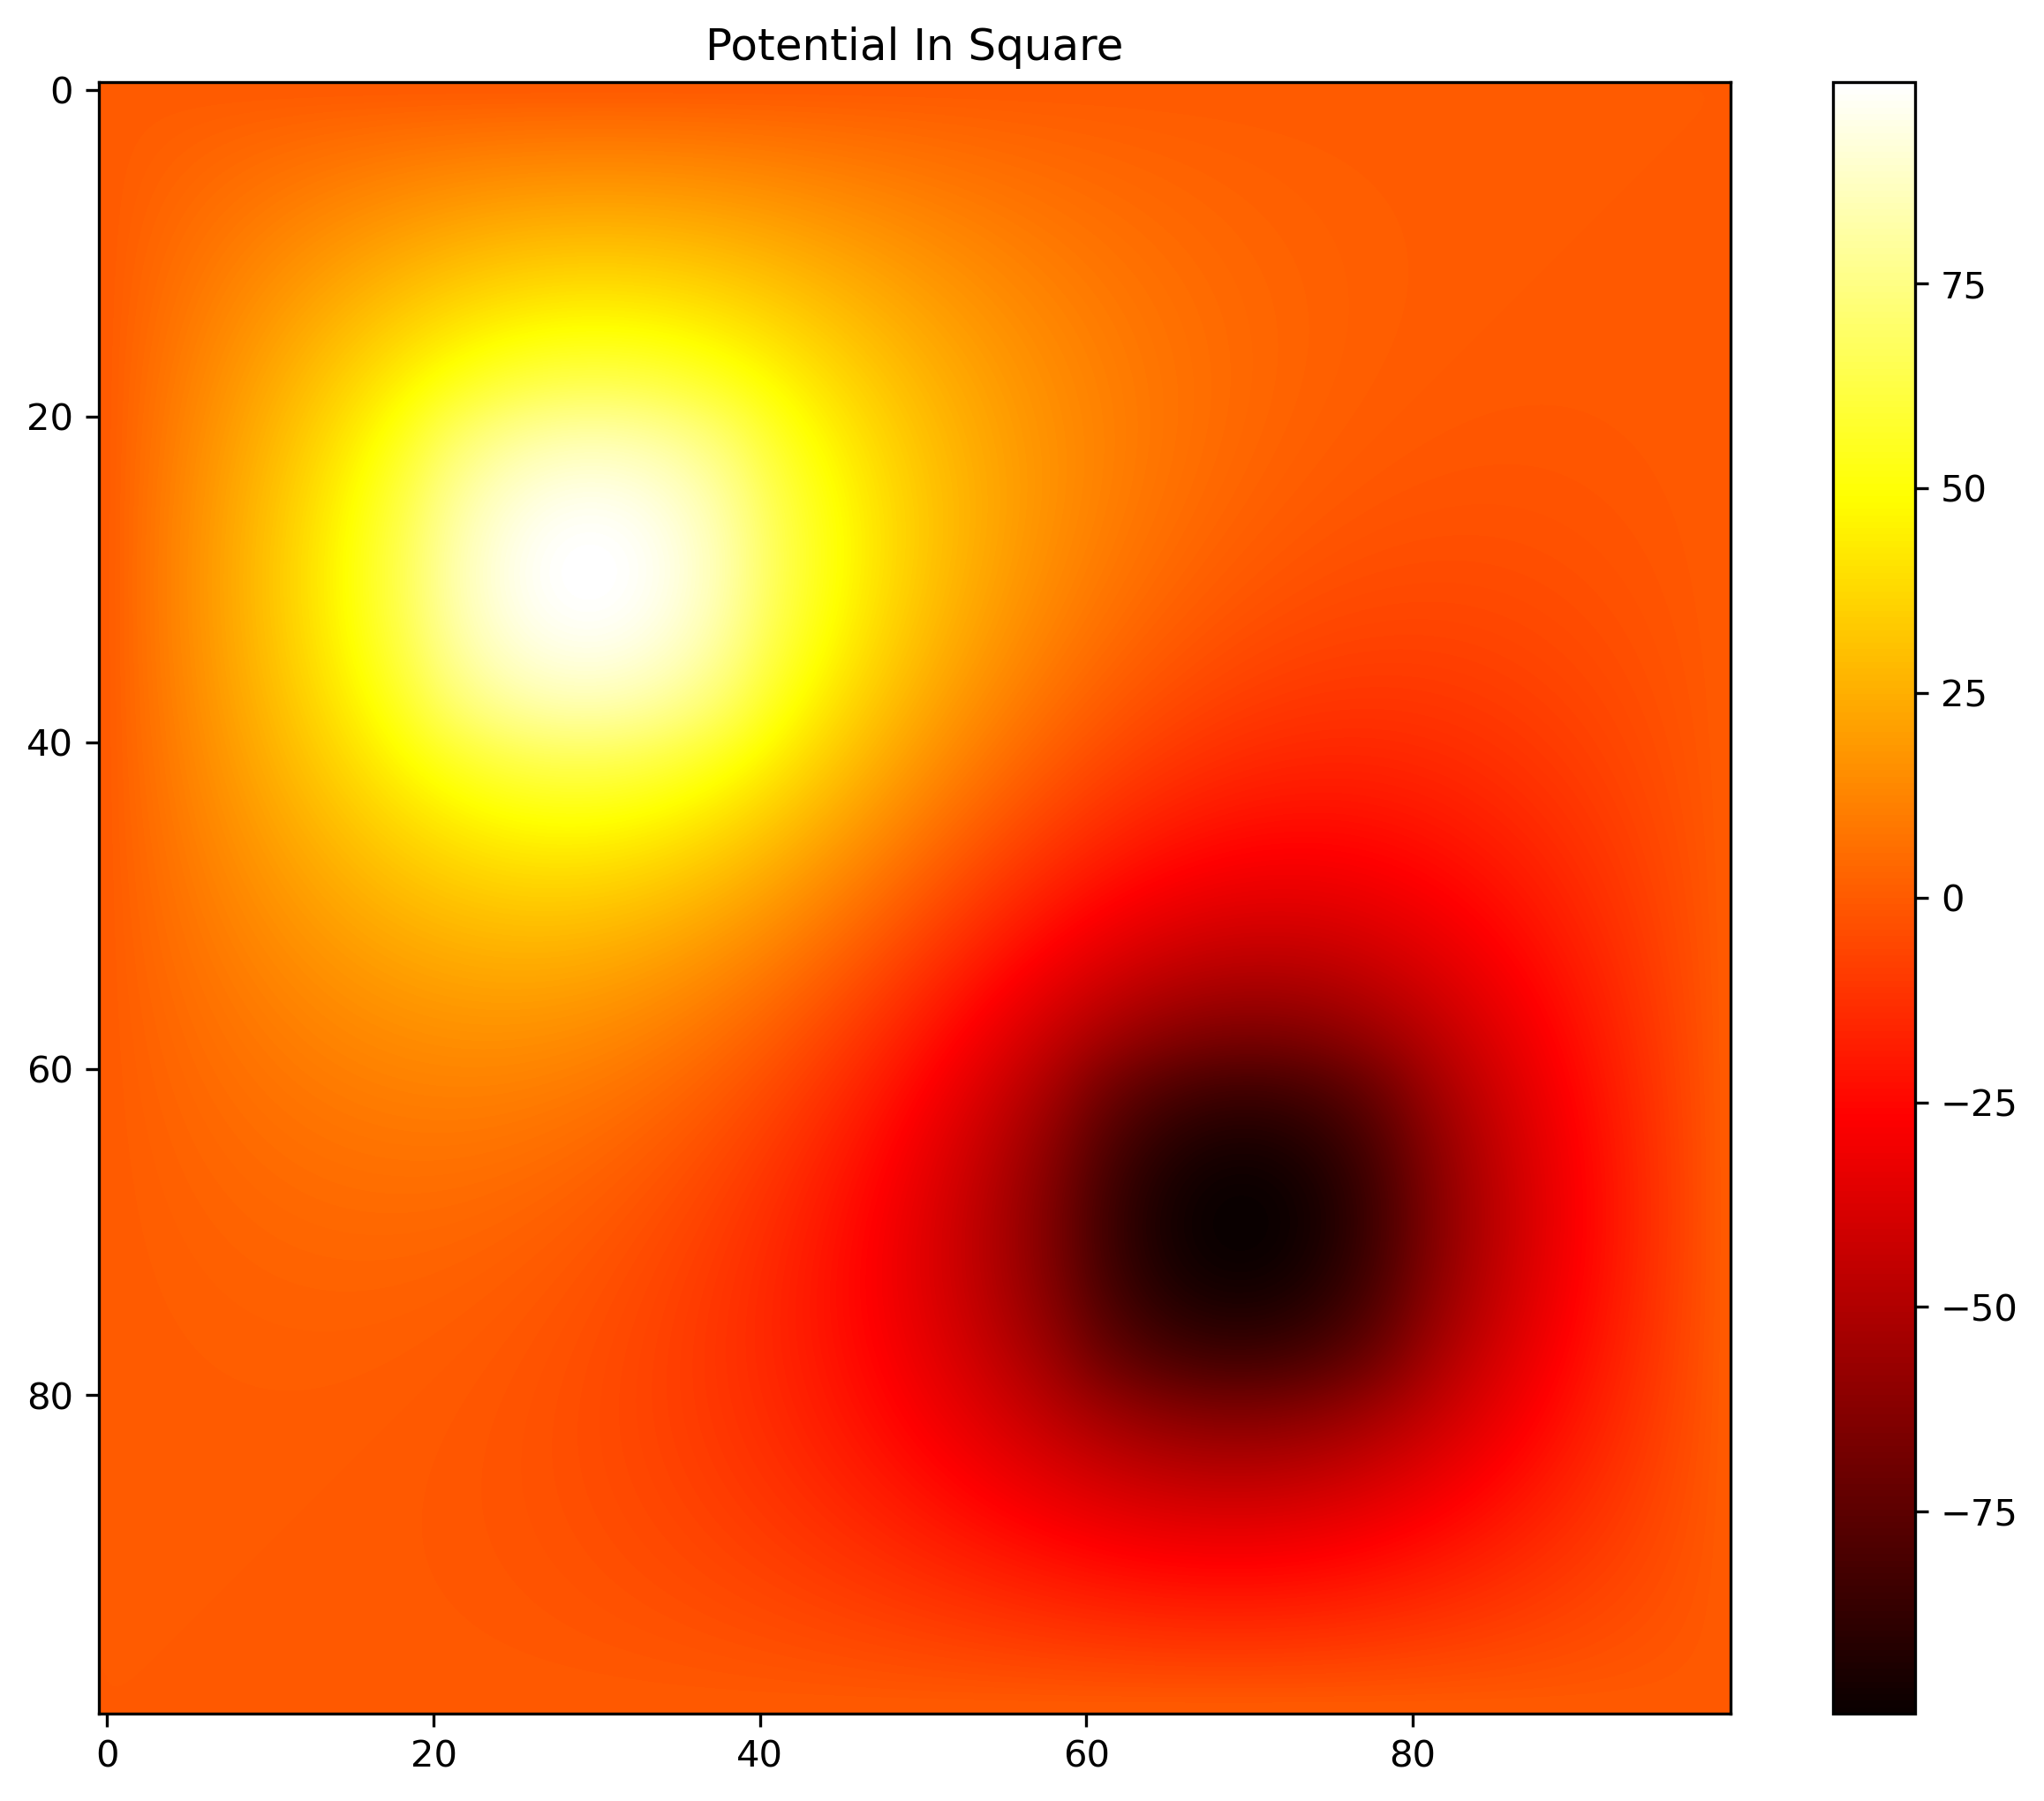

In [8]:
V = poisson_solver(V, rho)
plt.show()
plt.figure(figsize=(10, 8), dpi=300)  # 提高图像分辨率
plt.imshow(V.cpu().numpy(), cmap='hot', interpolation='bicubic')
plt.colorbar()
plt.title('Potential In Square')
plt.show()

再次注意，正电荷和负电荷的位置我是和雨课堂调换了一下，这并不影响！

这张图我运行了100000次迭代，用时30.5秒完成。效率远高于传统PDE解法

## Problem 4 Al棒的热传导

差分法求该PDE且与解析解进行对比。下图左为数值解，下图右为解析解。（解这个CPU还蛮快的）

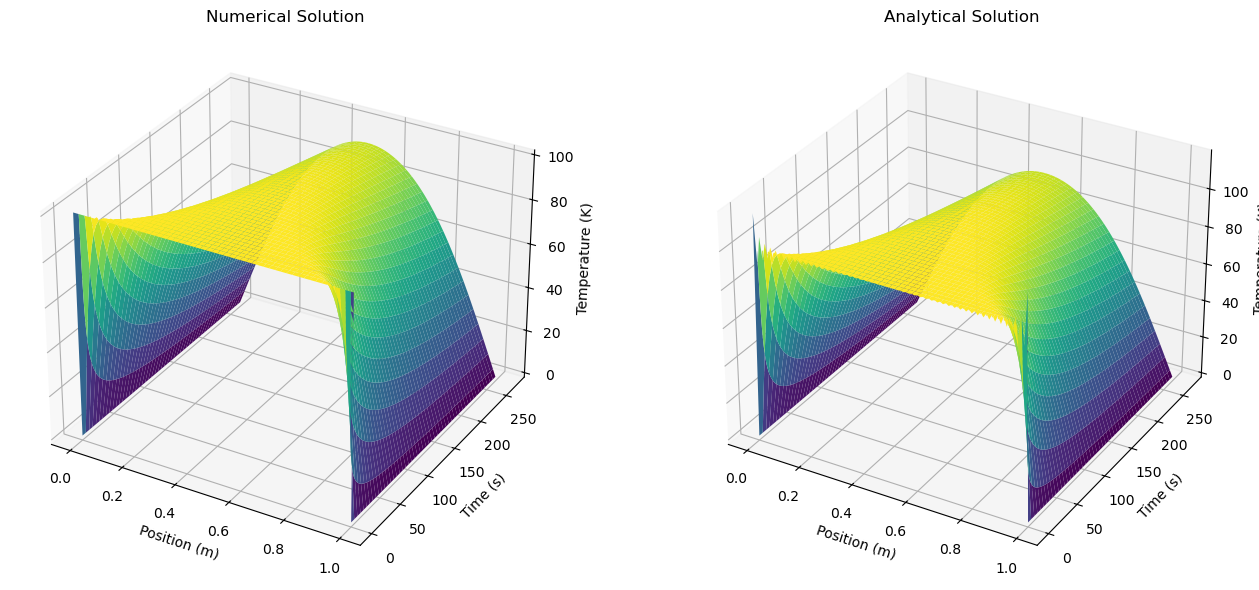

In [4]:

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 参数定义
L = 1.0
K = 273.0
C = 900.0
rho = 2700.0
T0 = 100.0
alpha = K / (C * rho)

# 网格定义
Nx = 100  # 空间步数
Nt = 3000  # 时间步数
dx = L / Nx
dt = 0.1 * dx**2 / alpha  # 稳定性条件
x = np.linspace(0, L, Nx)
t = np.linspace(0, Nt*dt, Nt)

# 初始化温度分布
T = np.zeros((Nx, Nt))
T[:, 0] = 100.0  # 初始条件

# 数值解
for j in range(0, Nt-1):
    for i in range(1, Nx-1):
        T[i, j+1] = T[i, j] + (alpha * dt / dx**2) * (T[i+1, j] - 2*T[i, j] + T[i-1, j])
    T[0, j+1] = 0.0  # 边界条件
    T[Nx-1, j+1] = 0.0  # 边界条件

# 解析解
def analytical_solution(x, t, N=100):
    sum_terms = np.zeros_like(x)
    for n in range(1, N+1, 2):
        kn = n * np.pi / L
        sum_terms += (4 * T0 / (n * np.pi)) * np.sin(kn * x) * np.exp(-kn**2 * K * t / (C * rho))
    return sum_terms

# 绘制结果
X, T_mesh = np.meshgrid(x, t)
fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X, T_mesh, T.T, cmap='viridis')
ax1.set_title('Numerical Solution')
ax1.set_xlabel('Position (m)')
ax1.set_ylabel('Time (s)')
ax1.set_zlabel('Temperature (K)')

ax2 = fig.add_subplot(122, projection='3d')
A_sol = np.array([analytical_solution(x, ti) for ti in t])
ax2.plot_surface(X, T_mesh, A_sol, cmap='viridis')
ax2.set_title('Analytical Solution')
ax2.set_xlabel('Position (m)')
ax2.set_ylabel('Time (s)')
ax2.set_zlabel('Temperature (K)')

plt.tight_layout()
plt.show()

## Problem 5 Al棒的热传导的不稳定解

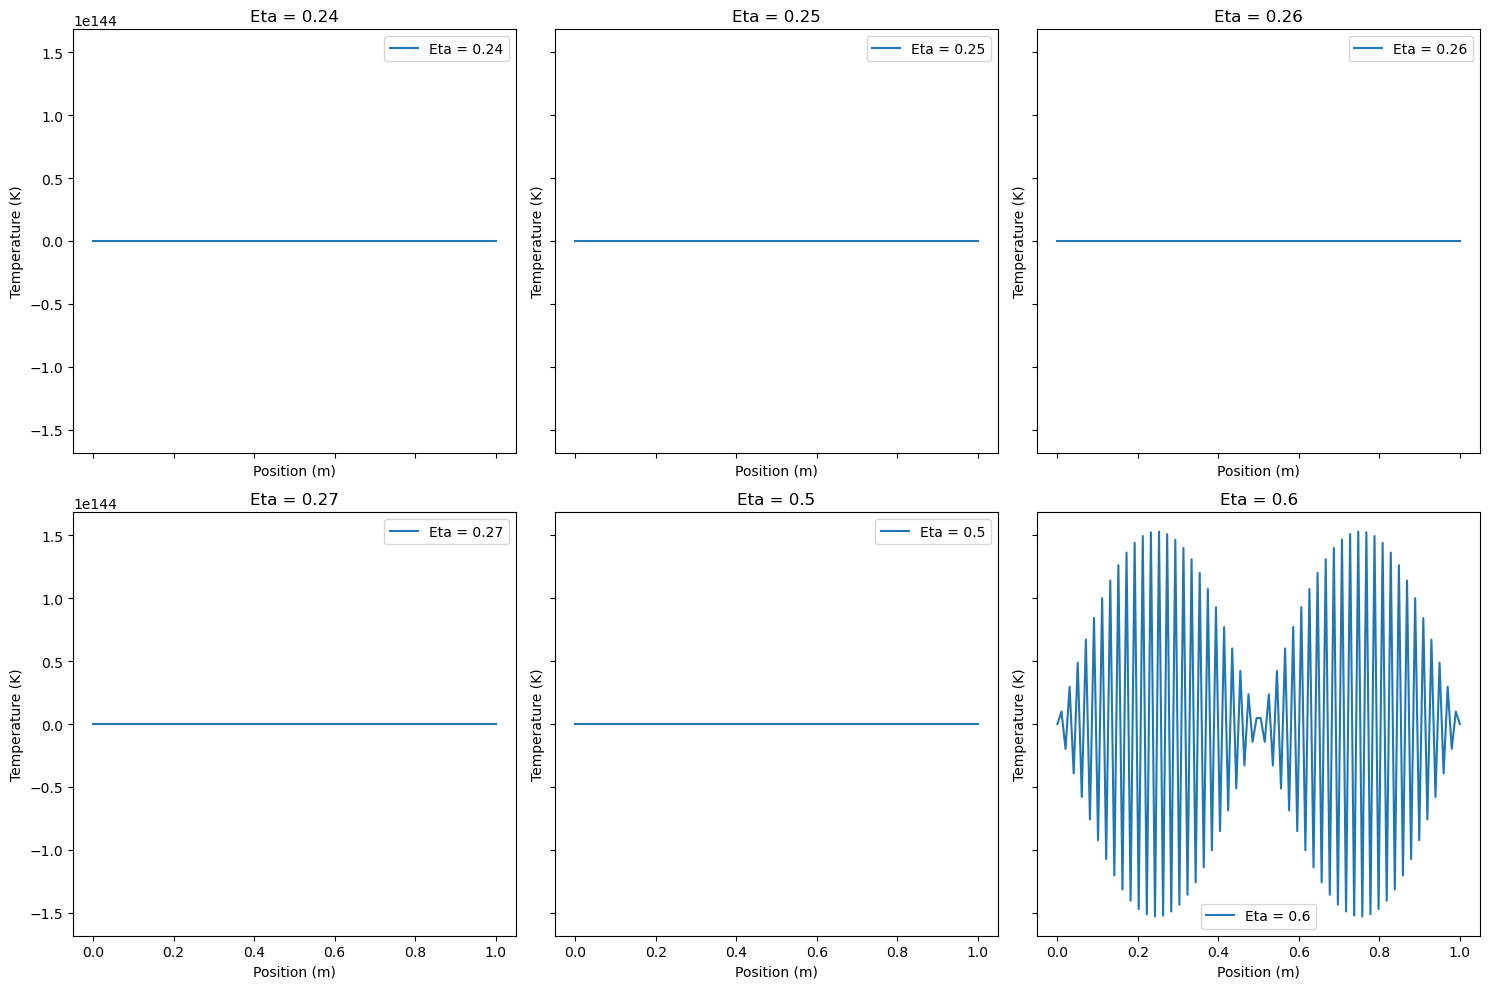

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# 参数定义
L = 1.0
K = 273.0
C = 900.0
rho = 2700.0
alpha = K / (C * rho)
dx = 0.01
Nx = int(L / dx)
x = np.linspace(0, L, Nx)

# 试验不同的 eta 值
etas = [0.24, 0.25, 0.26, 0.27, 0.5, 0.6]  # 包括大于和小于0.25的情况
time_steps = 1000

# 画图
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()

for index, eta in enumerate(etas):
    dt = eta * dx**2 / alpha
    T = np.ones(Nx) * 100  # 初始条件
    T[0] = T[-1] = 0  # 边界条件

    for _ in range(time_steps):
        T_new = T.copy()
        for i in range(1, Nx-1):
            T_new[i] = T[i] + eta * (T[i+1] - 2*T[i] + T[i-1])
        T = T_new
        T[0] = T[-1] = 0  # 保持边界条件

    axes[index].plot(x, T, label=f'Eta = {eta}')
    axes[index].set_title(f'Eta = {eta}')
    axes[index].set_xlabel('Position (m)')
    axes[index].set_ylabel('Temperature (K)')
    axes[index].legend()

plt.tight_layout()
plt.show()




我在这里index了它大于和小于0.25的情况，这东西在$$ \eta>0.5 $$的时候出现了不稳定解。

接近或略低于 0.5 时解可能还是稳定的，这可以帮我们了解显式方法保持稳定的条件，并且何时需要改用其他更稳定的数值方法如隐式或Crank-Nicolson方法

## Problem 6 双Al棒的热传导PDE

注：原题目中的$50K$等数据有问题，毕竟冰水比Al棒热了，所以我改成了摄氏度。比如铝棒是50°和100°，冰水混合为0°

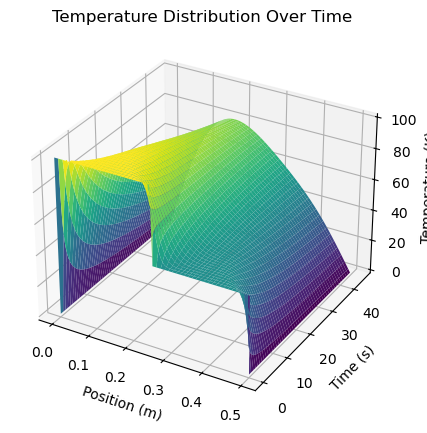

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 参数定义
L = 0.5  # 总长度
K = 273.0
C = 900.0
rho = 2700.0
alpha = K / (C * rho)

# 网格定义
Nx = 100  # 空间步数
Nt = 2000  # 时间步数
dx = L / Nx
dt = 0.1 * dx**2 / alpha  # 稳定性条件
x = np.linspace(0, L, Nx)
t = np.linspace(0, Nt*dt, Nt)

# 初始化温度分布
T = np.zeros((Nx, Nt))
T[:Nx//2, 0] = 100.0  # 第一根铝棒初始100度
T[Nx//2:, 0] = 50.0   # 第二根铝棒初始50度

# 数值解
for j in range(0, Nt-1):
    for i in range(1, Nx-1):
        T[i, j+1] = T[i, j] + (alpha * dt / dx**2) * (T[i+1, j] - 2*T[i, j] + T[i-1, j])
    # 边界条件
    T[0, j+1] = 0.0  # 左端在冰水中
    T[Nx-1, j+1] = 0.0  # 右端在冰水中

# 绘制结果
X, T_mesh = np.meshgrid(x, t)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T_mesh, T.T, cmap='viridis')
ax.set_title('Temperature Distribution Over Time')
ax.set_xlabel('Position (m)')
ax.set_ylabel('Time (s)')
ax.set_zlabel('Temperature (K)')

plt.show()


## Problem 7 非绝热体中牛顿冷却修正

在差分方程中加入牛顿冷却项，由温度差 $ T(x, t) - T_e $引起的额外热损失进行修正：
$$T_i^{j+1} = T_i^j + \eta \left( T_{i+1}^j - 2T_i^j + T_{i-1}^j \right) - h \Delta t \left( T_i^j - T_e \right) $$

这里$ \eta = \frac{K \Delta t}{C \rho \Delta x^2} $，$ h $ 是环境热交换系数,假定取空气自然对流下的参考数据$h=5W/(m^2K)$，$ T_e $ 是环境温度（取昆明最近的气温24°）

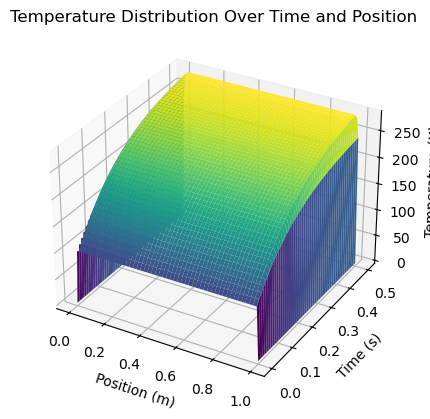

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 参数
L = 1.0          # 铝棒长度
K = 273.0        # 热导率
C = 900.0        # 比热容
rho = 2700.0     # 密度
alpha = K / (C * rho)  # 热扩散率
Te = 297.15        # 环境温度
h = 5       # 热交换系数
dx = 0.01
Nx = int(L / dx)
dt = 0.001
Nt = 500
eta = alpha * dt / dx**2

# 初始条件
T = np.ones(Nx) * 100.0
T[0] = T[-1] = 0.0
temperature_matrix = np.zeros((Nx, Nt))  # 保存每个时间步的温度数据

# 数值解
for j in range(Nt):
    T_new = T.copy()
    for i in range(1, Nx-1):
        T_new[i] = T[i] + eta * (T[i+1] - 2*T[i] + T[i-1]) - h * dt * (T[i] - Te)
    T_new[0], T_new[-1] = 0.0, 0.0  # 维持边界条件
    T = T_new
    temperature_matrix[:, j] = T

# 绘图
x = np.linspace(0, L, Nx)
t = np.linspace(0, Nt*dt, Nt)
X, T = np.meshgrid(x, t)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, temperature_matrix.T, cmap='viridis')
ax.set_title('Temperature Distribution Over Time and Position')
ax.set_xlabel('Position (m)')
ax.set_ylabel('Time (s)')
ax.set_zlabel('Temperature (K)')

plt.show()

